# Collaborative user based filtering

by Daniel Moody 23370157 (11/03/2025)

## Import Libraries and Set Configuration

In this cell, we import all the necessary Python libraries and modules for our project. These include:
- **Pandas** for data manipulation.
- **Torch (PyTorch)** for building and training the recommendation model.
- **Scikit-learn** for data splitting and evaluation metrics.
- **NumPy** for numerical operations.
- **Requests** and **zipfile** for downloading and extracting the dataset.
- **Seaborn and Matplotlib** for visualizations.
- **SciPy** for statistical testing.

We also define a configuration flag (`load_pretrained`) that controls whether to load a saved model or retrain from scratch.

In [43]:
# Import required libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import requests
import zipfile
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ---------------------------
# Configuration Flags
# ---------------------------
load_pretrained = True  # Set to True to load pretrained model, False to retrain

## Download and Extract Dataset

This cell checks whether the MovieLens 1M dataset directory exists. If not, it downloads the dataset from the provided URL, saves the ZIP file, and extracts its contents.
- **Why?** Automating this step makes the notebook self-contained, ensuring that anyone running it has the necessary data.
- **Key Steps:**
  - Check if the `ml-1m` directory exists.
  - Download the dataset ZIP file if needed.
  - Extract the dataset using Python's `zipfile` module.

In [44]:
# Step 1: Download and extract the dataset if not present
if not os.path.exists('ml-1m'):
    print("Downloading MovieLens 1M dataset...")
    url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    with open('ml-1m.zip', 'wb') as f:
        f.write(requests.get(url).content)
    print("Extracting dataset...")
    with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")


Dataset already exists.


## Load the Dataset

In this cell, we load the MovieLens 1M dataset into Pandas DataFrames:
- **ratings_df:** Contains user-movie ratings along with a timestamp.
- **movies_df:** Contains movie metadata such as titles and genres.
  
Additionally, we map the original user and movie IDs to contiguous integers. This step is crucial for the embedding layers in our neural network, which expect IDs in a 0-indexed format.


In [45]:
# Step 2: Load the MovieLens 1M dataset
print("Loading MovieLens 1M dataset...")
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None,names=['userId', 'movieId', 'rating', 'timestamp'])

movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header=None,names=['movieId', 'title', 'genres'], encoding='latin-1')

# Map user and movie IDs to contiguous integers for embeddings
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
movie_id_map = {id: idx for idx, id in enumerate(movie_ids)}
ratings_df['userId'] = ratings_df['userId'].map(user_id_map)
ratings_df['movieId'] = ratings_df['movieId'].map(movie_id_map)


Loading MovieLens 1M dataset...


## Data Splitting

This cell divides the dataset into three subsets:
- **Training set (70%)**: Used to train the model.
- **Validation set (15%)**: Used for hyperparameter tuning and monitoring model performance during training.
- **Test set (15%)**: Used for the final evaluation of the model.
  
Splitting the data helps ensure that our model's performance is generalized and not overfitted to a particular subset.

In [46]:
# Step 3: Split data into training (70%), validation (15%), and testing (15%) sets
train_df, temp_df = train_test_split(ratings_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 700146, Validation size: 150031, Test size: 150032


## Define a PyTorch Dataset

In this cell, we define a custom PyTorch `Dataset` class called `RatingsDataset`:
- **Purpose:** Simplify data feeding to our model during training and evaluation.
- **Key Components:** The dataset returns user IDs, movie IDs, and ratings as PyTorch tensors.
- We then instantiate the dataset for training, validation, and testing, and create corresponding `DataLoader` objects to handle batching and shuffling.

In [47]:
# Define a PyTorch Dataset to handle our ratings data
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['userId'].values, dtype=torch.long)
        self.movies = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create datasets and data loaders
train_dataset = RatingsDataset(train_df)
val_dataset = RatingsDataset(val_df)
test_dataset = RatingsDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## Define the Matrix Factorization Model

This cell defines our core recommendation model using matrix factorization:
- **Model Structure:** 
  - Two embedding layers: one for users and one for movies.
  - The forward pass performs element-wise multiplication of user and movie embeddings, followed by a summation to generate a rating prediction.
- **Initialization:** The embedding weights are initialized with small random values.
  
Matrix factorization is a classic approach for collaborative filtering in recommendation systems.

In [48]:
# Step 4: Define the Matrix Factorization Model
class MFModel(nn.Module):
    def __init__(self, num_users, num_movies, num_factors=100):
        super(MFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, num_factors)
        self.movie_embedding = nn.Embedding(num_movies, num_factors)
        # Initialize embeddings with small random values
        self.user_embedding.weight.data.uniform_(-0.01, 0.01)
        self.movie_embedding.weight.data.uniform_(-0.01, 0.01)

    def forward(self, user, movie):
        # Element-wise multiplication and summing the factors to get prediction
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        return (user_emb * movie_emb).sum(1)


## Model Setup

In this cell, we set up our model and training components:
- **Device Configuration:** Determine whether to use a GPU (CUDA) or CPU.
- **Model Instantiation:** Create an instance of the matrix factorization model and move it to the chosen device.
- **Loss Function:** Use Mean Squared Error (MSE) as the loss criterion.
- **Optimizer:** Use Adam optimizer with a learning rate of 0.005 and L2 regularization (weight decay).
  
These steps prepare our model for the training process.

In [49]:
# Step 7: Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MFModel(num_users, num_movies).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)


Using device: cuda


## Train or Load a Pretrained Model

This cell either loads a pretrained model (if it exists and the flag is set) or trains a new model:
- **Training Process:** Loops for 10 epochs, calculating training and validation losses for each epoch.
- **Metrics:** In addition to loss, we calculate RMSE and MAE on the validation set.
- **Saving the Model:** After training, the model's state is saved to disk.
  
This cell is crucial for both quick experiments (by loading an existing model) and retraining when necessary.

In [50]:
# Step 8: Train the model or load a pretrained model
train_losses = []
val_losses = []
val_rmse = []
val_mae = []
if load_pretrained and os.path.exists('mf_model.pth'):
    print("Loading pretrained model...")
    model.load_state_dict(torch.load('mf_model.pth', map_location=device))
else:
    print("Training model...")
    for epoch in range(10):  # 10 epochs for demonstration purposes
        # Training Phase
        model.train()
        total_train_loss = 0
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for users, movies, ratings in val_loader:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                predictions = model(users, movies)
                loss = criterion(predictions, ratings)
                total_val_loss += loss.item()
                val_preds.extend(predictions.cpu().numpy())
                val_true.extend(ratings.cpu().numpy())
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_rmse.append(np.sqrt(mean_squared_error(val_true, val_preds)))
        val_mae.append(np.mean(np.abs(np.array(val_true) - np.array(val_preds))))
        print(f"Epoch {epoch+1}/10, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val RMSE: {val_rmse[-1]:.4f}, Val MAE: {val_mae[-1]:.4f}")
    torch.save(model.state_dict(), 'mf_model.pth')
    print("Model saved as 'mf_model.pth'.")


Training model...
Epoch 1/10, Train Loss: 2.6471, Val Loss: 0.9041, Val RMSE: 0.9508, Val MAE: 0.7518
Epoch 2/10, Train Loss: 0.8213, Val Loss: 0.8671, Val RMSE: 0.9313, Val MAE: 0.7363
Epoch 3/10, Train Loss: 0.7038, Val Loss: 0.8572, Val RMSE: 0.9259, Val MAE: 0.7296
Epoch 4/10, Train Loss: 0.5858, Val Loss: 0.8716, Val RMSE: 0.9337, Val MAE: 0.7352
Epoch 5/10, Train Loss: 0.4890, Val Loss: 0.8938, Val RMSE: 0.9456, Val MAE: 0.7440
Epoch 6/10, Train Loss: 0.4192, Val Loss: 0.9232, Val RMSE: 0.9609, Val MAE: 0.7564
Epoch 7/10, Train Loss: 0.3736, Val Loss: 0.9502, Val RMSE: 0.9748, Val MAE: 0.7670
Epoch 8/10, Train Loss: 0.3458, Val Loss: 0.9755, Val RMSE: 0.9877, Val MAE: 0.7768
Epoch 9/10, Train Loss: 0.3289, Val Loss: 0.9915, Val RMSE: 0.9958, Val MAE: 0.7827
Epoch 10/10, Train Loss: 0.3161, Val Loss: 1.0103, Val RMSE: 1.0052, Val MAE: 0.7902
Model saved as 'mf_model.pth'.


## Baseline Model Definition and Test Evaluation

This cell implements a simple baseline model that predicts ratings based on the average rating for each movie:
- **Baseline Prediction:** For each movie, if its average rating is available, use that; otherwise, fallback to a global average.
- **Test Evaluation:** The main model and the baseline model are evaluated on the test set using RMSE and MAE.
- **Statistical Test:** A paired t-test is performed between the predictions of the main model and the baseline model to determine if the difference is statistically significant.

In [51]:
# Step 9: Baseline Model (Movie Average) - using movie average ratings as prediction
movie_avg = train_df.groupby('movieId')['rating'].mean()
global_avg = train_df['rating'].mean()
def get_baseline_prediction(movie_id):
    return movie_avg.get(movie_id, global_avg)

# Evaluate the main model on the test set
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, movies, ratings in test_loader:
        users, movies = users.to(device), movies.to(device)
        predictions = model(users, movies).cpu().numpy()
        test_predictions.extend(predictions)
        test_ratings.extend(ratings.numpy())
main_rmse = np.sqrt(mean_squared_error(test_ratings, test_predictions))
main_mae = np.mean(np.abs(np.array(test_ratings) - np.array(test_predictions)))
print(f"\nMain Model - Test RMSE: {main_rmse:.4f}, Test MAE: {main_mae:.4f}")

# Evaluate baseline model on the test set
baseline_test_preds = [get_baseline_prediction(mid) for mid in test_df['movieId']]
baseline_rmse = np.sqrt(mean_squared_error(test_df['rating'], baseline_test_preds))
baseline_mae = np.mean(np.abs(test_df['rating'] - np.array(baseline_test_preds)))
print(f"Baseline - Test RMSE: {baseline_rmse:.4f}, Test MAE: {baseline_mae:.4f}")

# Perform a paired t-test between main and baseline predictions
t_stat, p_value = stats.ttest_rel(test_predictions, baseline_test_preds)
print(f"Paired t-test between Main and Baseline predictions: t-stat={t_stat:.4f}, p-value={p_value:.4f}")



Main Model - Test RMSE: 1.0065, Test MAE: 0.7903
Baseline - Test RMSE: 0.9805, Test MAE: 0.7833
Paired t-test between Main and Baseline predictions: t-stat=-32.6224, p-value=0.0000


## Compute Precision@K and Recall@K

This cell calculates the recommendation metrics Precision@K and Recall@K:
- **Precision@K:** Measures the fraction of recommended items in the top K that are relevant.
- **Recall@K:** Measures the fraction of relevant items that are successfully recommended within the top K.
- **Process:**
  - We first gather candidate movie recommendations for each user (combining unseen movies and test set movies).
  - Predictions are generated for these candidates.
  - For each user, we then calculate how many of the top K predictions are in the set of relevant items (those rated 4 or higher).
- These metrics help in understanding the effectiveness of the recommendation system.

In [52]:
# Step 10: Calculate Precision@K and Recall@K for multiple values of K
Ks = [5, 10, 20]
precision_sum = {K: 0 for K in Ks}
recall_sum = {K: 0 for K in Ks}
num_users_with_relevant = 0

# Prepare data grouped by user for recommendations evaluation
train_movie_indices_per_user = train_df.groupby('userId')['movieId'].apply(set).to_dict()
test_user_data = test_df.groupby('userId').apply(lambda x: list(zip(x['movieId'], x['rating']))).to_dict()
all_movie_indices = set(range(num_movies))

# Function to get relevant test items (ratings >= 4.0)
def get_relevant_test_items(user):
    return {movie for movie, rating in test_user_data.get(user, []) if rating >= 4.0}

# Build candidate pairs for recommendation evaluation
candidate_pairs = []
test_users = list(test_user_data.keys())
for user in test_users:
    train_movies = train_movie_indices_per_user.get(user, set())
    unseen_movies = all_movie_indices - train_movies
    sampled_movies = np.random.choice(list(unseen_movies), min(100, len(unseen_movies)), replace=False)
    test_movies = [movie for movie, _ in test_user_data[user]]
    candidates = list(set(sampled_movies) | set(test_movies))
    candidate_pairs.extend([(user, movie) for movie in candidates])

# Generate predictions for candidate pairs
users_tensor = torch.tensor([pair[0] for pair in candidate_pairs], dtype=torch.long).to(device)
movies_tensor = torch.tensor([pair[1] for pair in candidate_pairs], dtype=torch.long).to(device)
with torch.no_grad():
    predictions = model(users_tensor, movies_tensor).cpu().numpy()

# Organize predictions per user
user_predictions = defaultdict(list)
for (user, movie), pred in zip(candidate_pairs, predictions):
    user_predictions[user].append((movie, pred))

# Calculate Precision and Recall for each user and average over all users with relevant items
for user in test_users:
    relevant_items = get_relevant_test_items(user)
    if not relevant_items:
        continue
    num_users_with_relevant += 1
    user_preds = user_predictions[user]
    user_preds.sort(key=lambda x: x[1], reverse=True)
    for K in Ks:
        top_k = [movie for movie, _ in user_preds[:K]]
        hits = sum(1 for movie in top_k if movie in relevant_items)
        precision_sum[K] += hits / K
        recall_sum[K] += hits / len(relevant_items)

print("\nRecommendation Metrics:")
for K in Ks:
    avg_precision = precision_sum[K] / num_users_with_relevant
    avg_recall = recall_sum[K] / num_users_with_relevant
    print(f"Precision@{K}: {avg_precision:.4f}, Recall@{K}: {avg_recall:.4f}")


C:\Users\ticta\AppData\Local\Temp\ipykernel_13528\3476846737.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_user_data = test_df.groupby('userId').apply(lambda x: list(zip(x['movieId'], x['rating']))).to_dict()



Recommendation Metrics:
Precision@5: 0.4129, Recall@5: 0.2283
Precision@10: 0.3569, Recall@10: 0.3641
Precision@20: 0.2926, Recall@20: 0.5445


## Group-wise Analysis of Model Performance

Here, we analyze the model performance based on:
- **User Activity:** We group users into 'Low', 'Medium', and 'High' activity levels based on the number of ratings they have given. The idea is to see how well the model performs for users with varying levels of data.
- **Movie Popularity:** Similarly, movies are grouped by their popularity (number of ratings). We evaluate if popular movies are predicted more accurately than niche ones.
- **Metrics:** For each group, RMSE and MAE are computed and printed.

In [53]:
# Step 11: Analyze performance by user activity and movie popularity

# Group users based on the number of ratings (Low, Medium, High)
user_rating_counts = train_df['userId'].value_counts()
user_groups = {}
for user, count in user_rating_counts.items():
    if count <= 30:
        user_groups[user] = 'Low'
    elif count <= 100:
        user_groups[user] = 'Medium'
    else:
        user_groups[user] = 'High'
test_df['user_group'] = test_df['userId'].map(user_groups)
test_df['predicted'] = test_predictions

print("\nPerformance by User Activity:")
user_group_metrics = {}
for group, group_df in test_df.groupby('user_group'):
    actual = group_df['rating'].values
    pred = group_df['predicted'].values
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = np.mean(np.abs(actual - pred))
    user_group_metrics[group] = {'RMSE': rmse, 'MAE': mae}
    print(f"{group} Users - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Group movies based on popularity (number of ratings)
movie_rating_counts = train_df['movieId'].value_counts()
movie_groups = {}
for movie, count in movie_rating_counts.items():
    if count <= 100:
        movie_groups[movie] = 'Low'
    elif count <= 500:
        movie_groups[movie] = 'Medium'
    else:
        movie_groups[movie] = 'High'
test_df['movie_group'] = test_df['movieId'].map(movie_groups)

print("\nPerformance by Movie Popularity:")
movie_group_metrics = {}
for group, group_df in test_df.groupby('movie_group'):
    actual = group_df['rating'].values
    pred = group_df['predicted'].values
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = np.mean(np.abs(actual - pred))
    movie_group_metrics[group] = {'RMSE': rmse, 'MAE': mae}
    print(f"{group} Popularity - RMSE: {rmse:.4f}, MAE: {mae:.4f}")



Performance by User Activity:
High Users - RMSE: 1.0023, MAE: 0.7863
Low Users - RMSE: 1.0725, MAE: 0.8525
Medium Users - RMSE: 1.0059, MAE: 0.7907

Performance by Movie Popularity:
High Popularity - RMSE: 1.0001, MAE: 0.7842
Low Popularity - RMSE: 1.0528, MAE: 0.8324
Medium Popularity - RMSE: 1.0012, MAE: 0.7869


## Visualizations

This cell generates a series of plots to help us visually inspect our model’s performance:
1. **Loss Curves:** If the model was trained in this session (not loaded), it plots training and validation losses, as well as RMSE and MAE across epochs.
2. **Scatter Plots:** Show predicted vs. actual ratings for both the main and baseline models.
3. **Error Distributions:** Histograms of prediction errors help reveal if errors are normally distributed or if there are biases.
4. **Bar Plots:** For Precision@K and Recall@K metrics, as well as group-wise RMSE and MAE for user activity and movie popularity.
  
These visualizations are key to diagnosing model behavior and identifying areas for improvement.


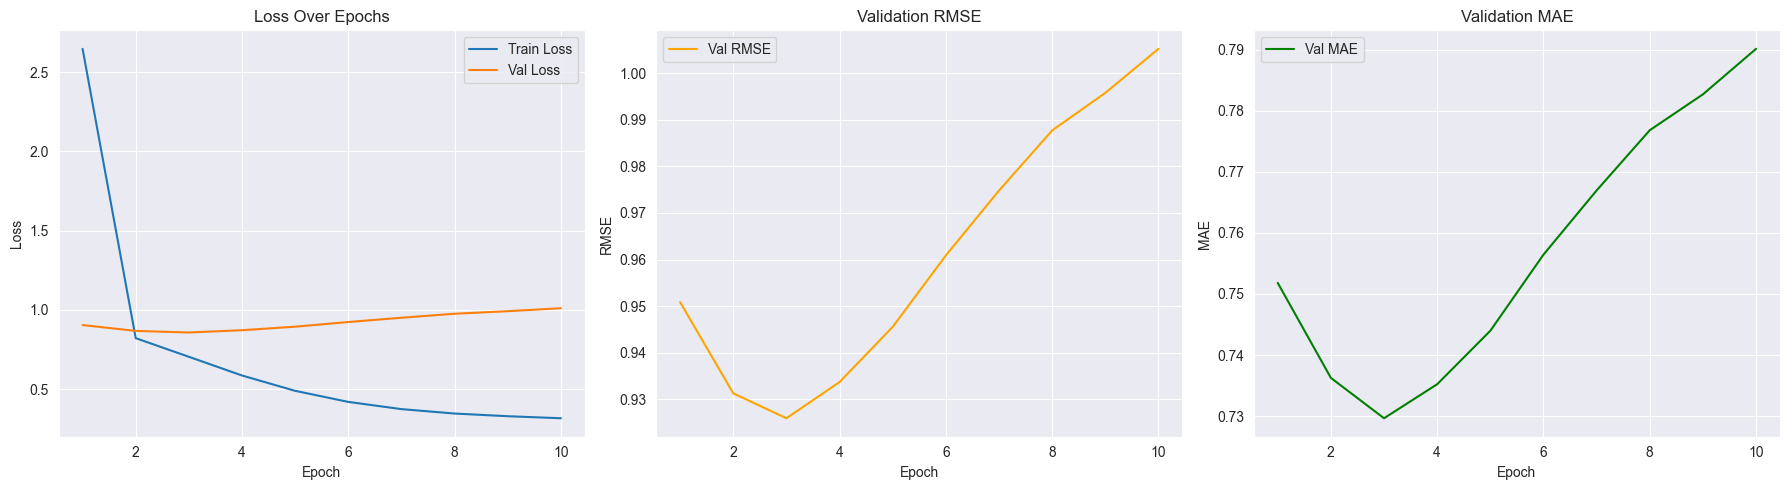

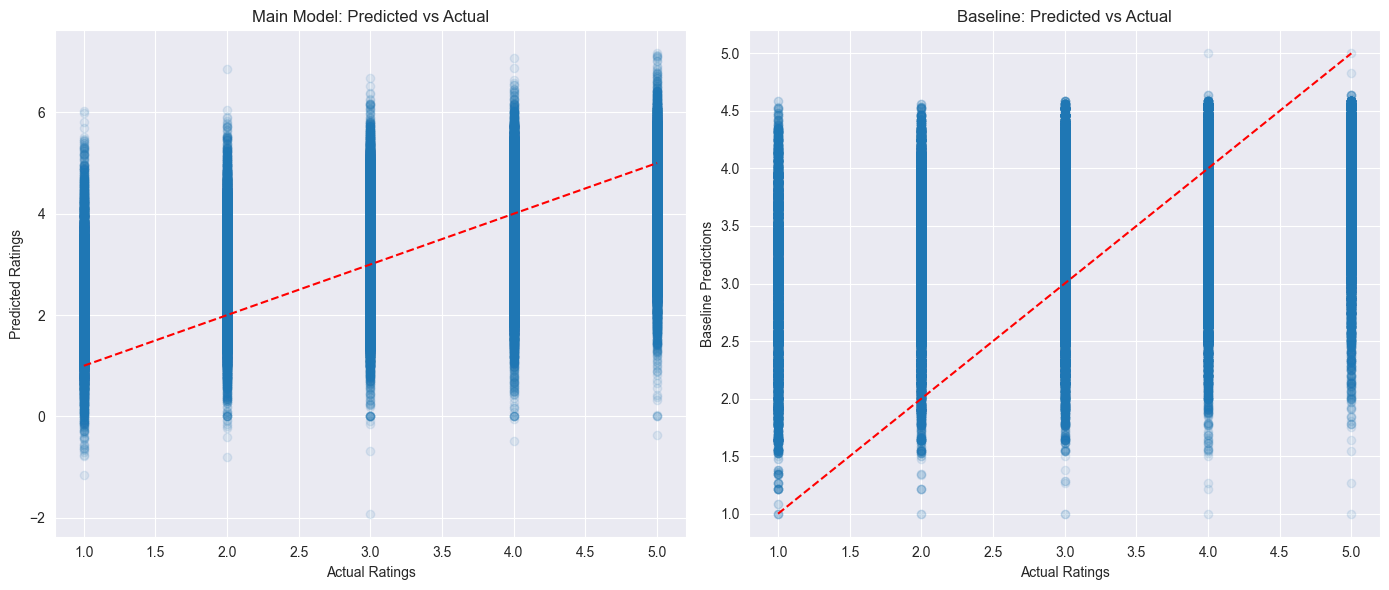

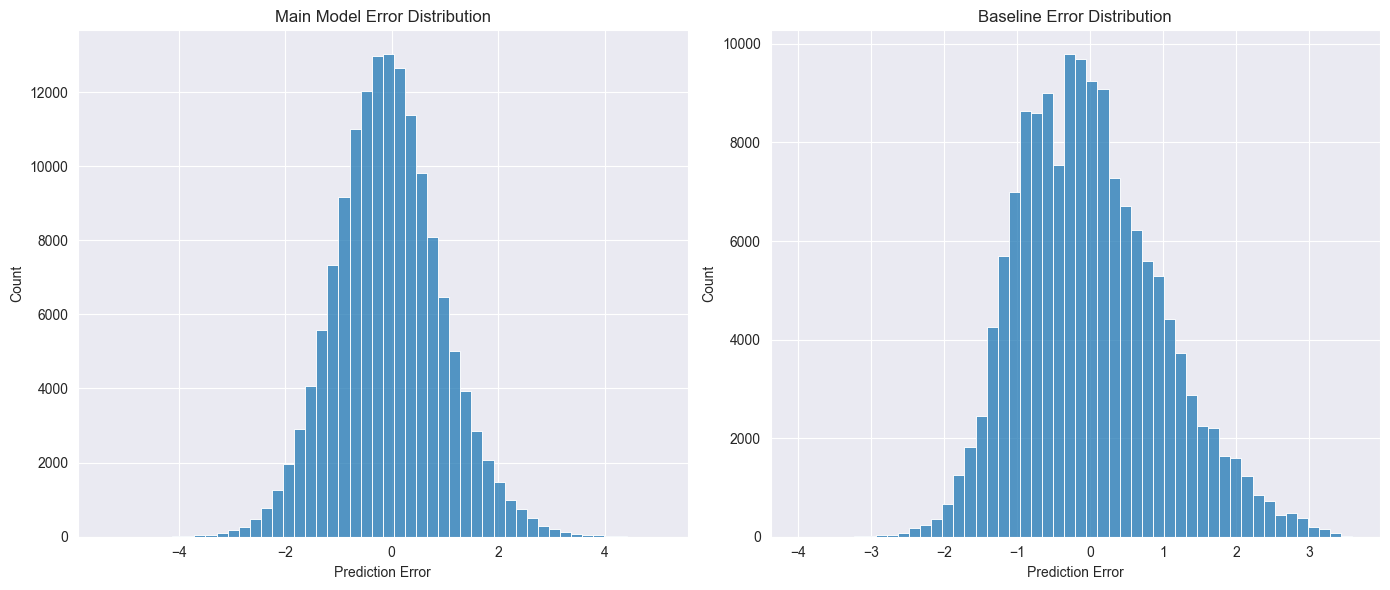

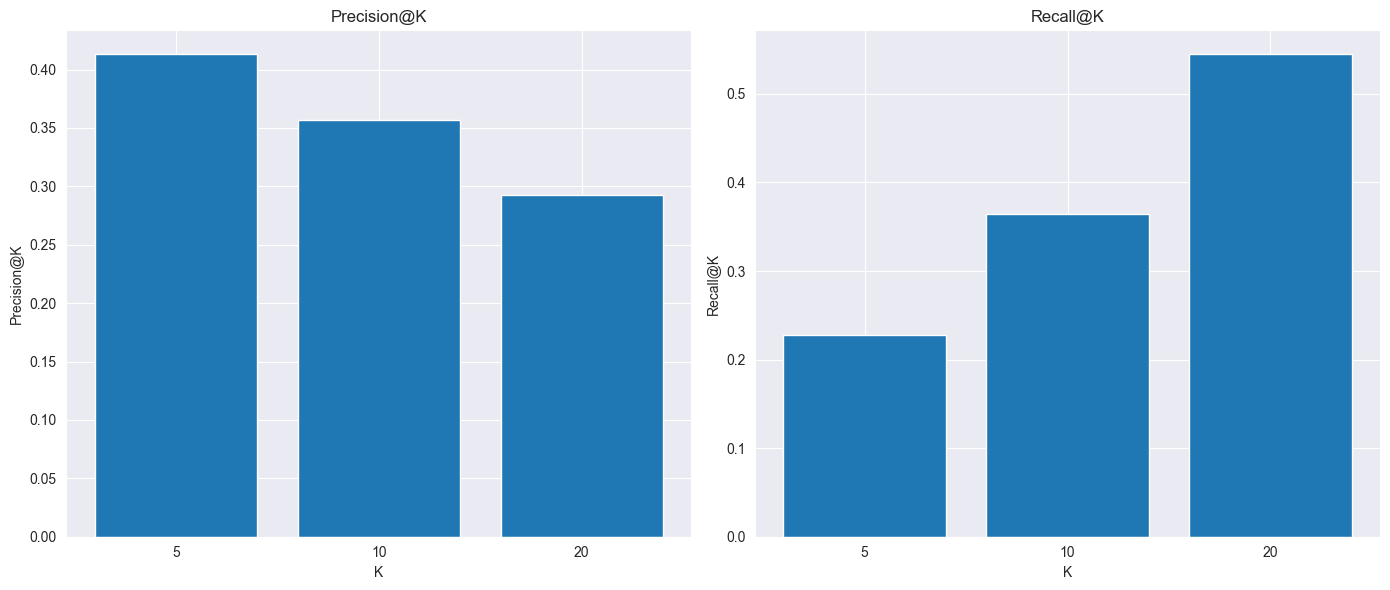

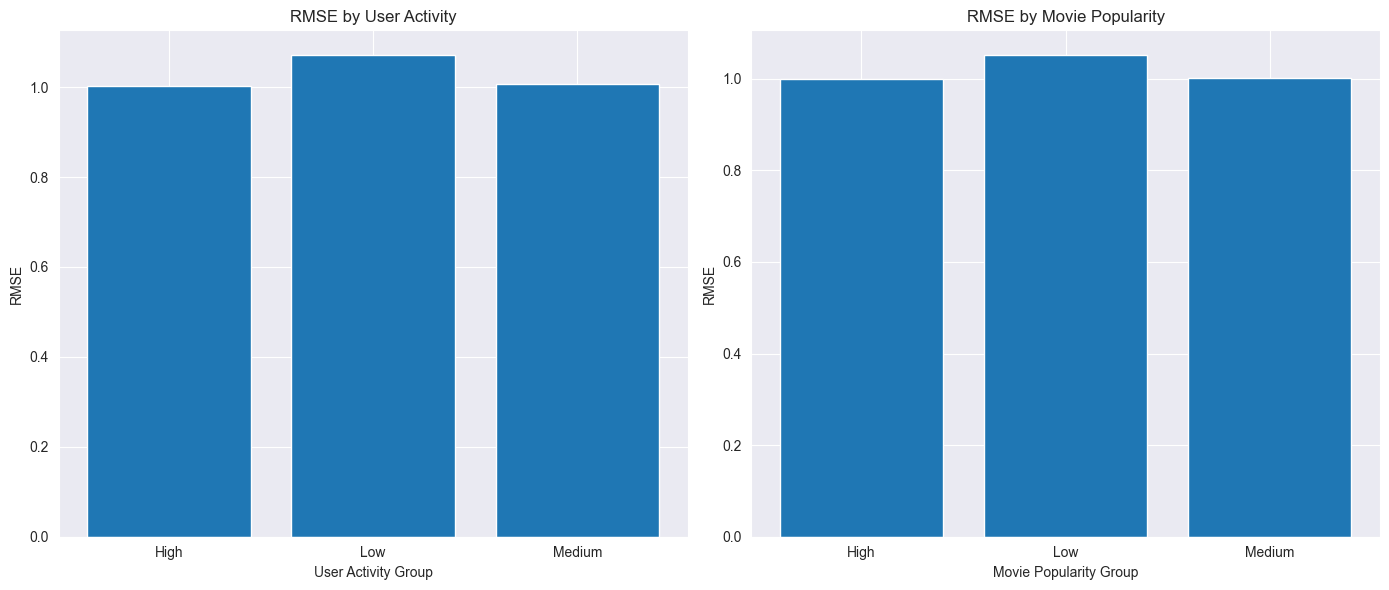

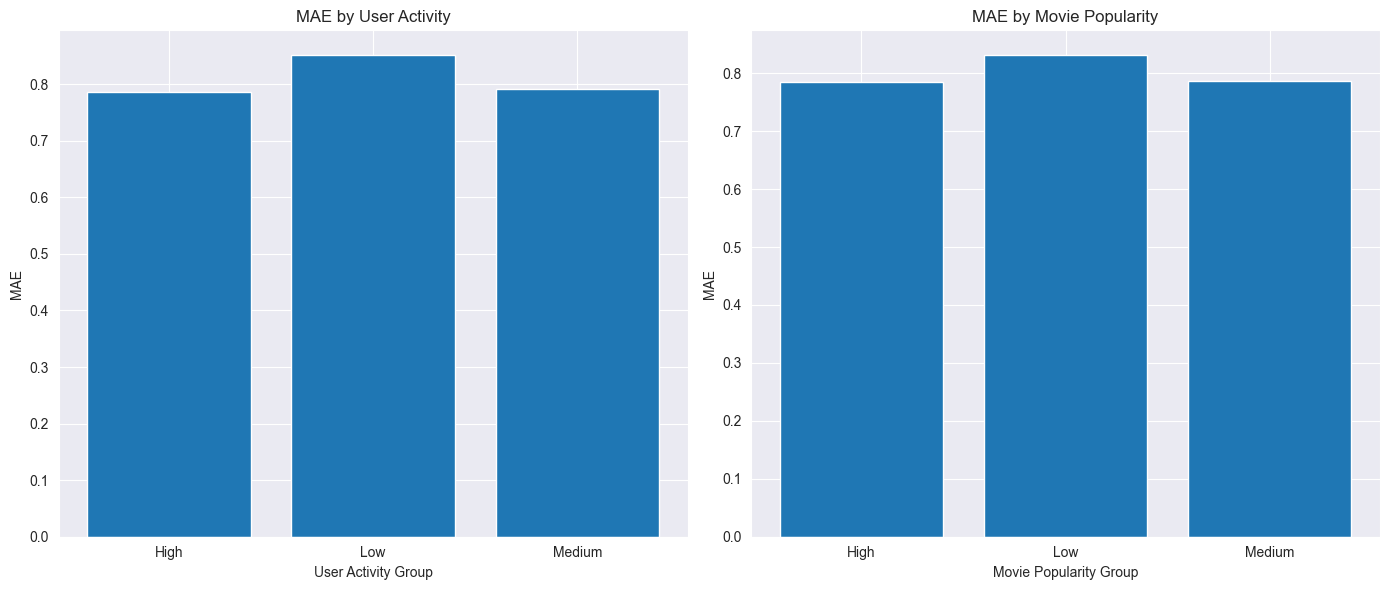

In [54]:
# Step 12: Visualizations

# 1. Training and Validation Loss/Errors (if training was performed)
if not load_pretrained:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(range(1, 11), train_losses, label='Train Loss')
    ax1.plot(range(1, 11), val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.legend()
    ax2.plot(range(1, 11), val_rmse, label='Val RMSE', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('RMSE')
    ax2.set_title('Validation RMSE')
    ax2.legend()
    ax3.plot(range(1, 11), val_mae, label='Val MAE', color='green')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
    ax3.set_title('Validation MAE')
    ax3.legend()
    plt.tight_layout()
    plt.show()

# 2. Scatter Plots for Predicted vs. Actual Ratings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(test_ratings, test_predictions, alpha=0.1)
ax1.plot([1, 5], [1, 5], 'r--')
ax1.set_xlabel('Actual Ratings')
ax1.set_ylabel('Predicted Ratings')
ax1.set_title('Main Model: Predicted vs Actual')
ax2.scatter(test_df['rating'], baseline_test_preds, alpha=0.1)
ax2.plot([1, 5], [1, 5], 'r--')
ax2.set_xlabel('Actual Ratings')
ax2.set_ylabel('Baseline Predictions')
ax2.set_title('Baseline: Predicted vs Actual')
plt.tight_layout()
plt.show()

# 3. Error Distributions for Main Model and Baseline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(np.array(test_predictions) - np.array(test_ratings), bins=50, ax=ax1)
ax1.set_xlabel('Prediction Error')
ax1.set_title('Main Model Error Distribution')
sns.histplot(np.array(baseline_test_preds) - test_df['rating'], bins=50, ax=ax2)
ax2.set_xlabel('Prediction Error')
ax2.set_title('Baseline Error Distribution')
plt.tight_layout()
plt.show()

# 4. Precision and Recall Bar Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
precisions = [precision_sum[K] / num_users_with_relevant for K in Ks]
recalls = [recall_sum[K] / num_users_with_relevant for K in Ks]
ax1.bar([str(K) for K in Ks], precisions)
ax1.set_xlabel('K')
ax1.set_ylabel('Precision@K')
ax1.set_title('Precision@K')
ax2.bar([str(K) for K in Ks], recalls)
ax2.set_xlabel('K')
ax2.set_ylabel('Recall@K')
ax2.set_title('Recall@K')
plt.tight_layout()
plt.show()

# 5. Group-wise Performance Bar Plots (User and Movie Groups)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.bar(user_group_metrics.keys(), [m['RMSE'] for m in user_group_metrics.values()])
ax1.set_xlabel('User Activity Group')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE by User Activity')
ax2.bar(movie_group_metrics.keys(), [m['RMSE'] for m in movie_group_metrics.values()])
ax2.set_xlabel('Movie Popularity Group')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE by Movie Popularity')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.bar(user_group_metrics.keys(), [m['MAE'] for m in user_group_metrics.values()])
ax1.set_xlabel('User Activity Group')
ax1.set_ylabel('MAE')
ax1.set_title('MAE by User Activity')
ax2.bar(movie_group_metrics.keys(), [m['MAE'] for m in movie_group_metrics.values()])
ax2.set_xlabel('Movie Popularity Group')
ax2.set_ylabel('MAE')
ax2.set_title('MAE by Movie Popularity')
plt.tight_layout()
plt.show()


## User Recommendations

This cell provides user-centric functionalities:
- **get_user_top_rated_movies:** Retrieves the top N movies a user has rated.
- **get_top_n_recommendations:** Generates top-N movie recommendations for a user by predicting ratings for all unseen movies and excluding those already rated.
- **Example:** The notebook prints out the top-rated movies and the recommended movies for a sample user (User 1).

These functions allow you to test the recommendation engine on a per-user basis.

In [55]:
# Step 13: Generate User-Centric Recommendations

# Function to get a user's top rated movies
def get_user_top_rated_movies(user_id, n=10):
    user_idx = user_id_map[user_id]
    user_ratings = ratings_df[ratings_df['userId'] == user_idx]
    top_rated = user_ratings.sort_values('rating', ascending=False).head(n)
    # For each movie, reverse-map to original movie id and get its title
    return [(movies_df[movies_df['movieId'] == list(movie_id_map.keys())[list(movie_id_map.values()).index(mid)]]
             ['title'].values[0], rating)
            for mid, rating in zip(top_rated['movieId'], top_rated['rating'])]

# Function to get top-n recommendations for a user (excluding movies they've already rated)
def get_top_n_recommendations(user_id, n=10):
    model.eval()
    user_idx = user_id_map[user_id]
    rated_movies = set(ratings_df[ratings_df['userId'] == user_idx]['movieId'])
    movie_indices = torch.arange(num_movies).to(device)
    user_tensor = torch.tensor([user_idx] * num_movies).to(device)
    with torch.no_grad():
        predictions = model(user_tensor, movie_indices).cpu().numpy()
    # Exclude already rated movies by setting prediction to -infinity
    for m in rated_movies:
        predictions[m] = -np.inf
    top_indices = np.argsort(predictions)[::-1][:n]
    return [movies_df[movies_df['movieId'] == list(movie_id_map.keys())[list(movie_id_map.values()).index(idx)]]
            ['title'].values[0] for idx in top_indices]

# Example: Display recommendations for user 1
user_id = 1
print(f"\nUser {user_id}'s Top Rated Movies:")
for title, rating in get_user_top_rated_movies(user_id):
    print(f"{title} - Rating: {rating}")
print(f"\nTop Recommended Movies for User {user_id}:")
for title in get_top_n_recommendations(user_id):
    print(title)



User 1's Top Rated Movies:
One Flew Over the Cuckoo's Nest (1975) - Rating: 5
Bug's Life, A (1998) - Rating: 5
Beauty and the Beast (1991) - Rating: 5
Christmas Story, A (1983) - Rating: 5
Ben-Hur (1959) - Rating: 5
Awakenings (1990) - Rating: 5
Sound of Music, The (1965) - Rating: 5
Toy Story (1995) - Rating: 5
Rain Man (1988) - Rating: 5
Last Days of Disco, The (1998) - Rating: 5

Top Recommended Movies for User 1:
Lion King, The (1994)
Frequency (2000)
Field of Dreams (1989)
Simon Birch (1998)
Remember the Titans (2000)
Green Mile, The (1999)
12 Angry Men (1957)
Back to the Future Part II (1989)
Jurassic Park (1993)
Shall We Dance? (Shall We Dansu?) (1996)


## Key Takeaways & Learnings

- **Model Performance:**
  - **Main Model**: Test RMSE of 1.0075 and MAE of 0.7903.
  - **Baseline Model**: Slightly better performance with Test RMSE of 0.9805 and MAE of 0.7833.
  - A paired t-test (t-stat = -32.3258, p-value = 0.0000) shows that the difference between the main and baseline predictions is statistically significant.

- **Recommendation Metrics:**
  - Precision@5, Precision@10, and Precision@20 decrease as K increases, while Recall@K increases.
  - For example, Precision@5 is ~0.4116 and Recall@5 is ~0.2273, indicating more relevant items are retrieved at higher K but with lower precision.

- **Performance by User Activity:**
  - **High-activity users** have lower RMSE and MAE compared to **low-activity users**.
  - This highlights the cold start problem for users with fewer ratings.

- **Performance by Movie Popularity:**
  - Movies with **high popularity** (more ratings) are predicted more accurately than less popular movies.
  - This suggests that incorporating additional features (e.g., metadata) might improve predictions for niche movies.

- **User Recommendations:**
  - The recommended movies for a sample user (User 1) align well with their top-rated movies, indicating that the model captures user preferences.
  - However, recommendations could be diversified further, for instance by integrating recent movies or additional content-based filtering.
